# Описание проекта


Компания "Чётенькое такси" собрала информацию о количестве заказов такси в аэропортах за прошлые периоды времени и хочет создать модель, которая будет прогнозировать количество заказов на следующий час. Это позволит компании привлекать больше водителей в периоды повышенной нагрузки и улучшать качество обслуживания клиентов. Модель должна достигать значения метрики RMSE не более 48 на тестовой выборке, что говорит о высокой точности предсказания.

# Импорт библиотек и данных

In [1]:
!pip install statsmodels
!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor, cv
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
#from pandas.core.common import fill_missing_names
plt.style.use('dark_background')

In [3]:
try:
  data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
  data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
print(data)

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]


# Анализ данных

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


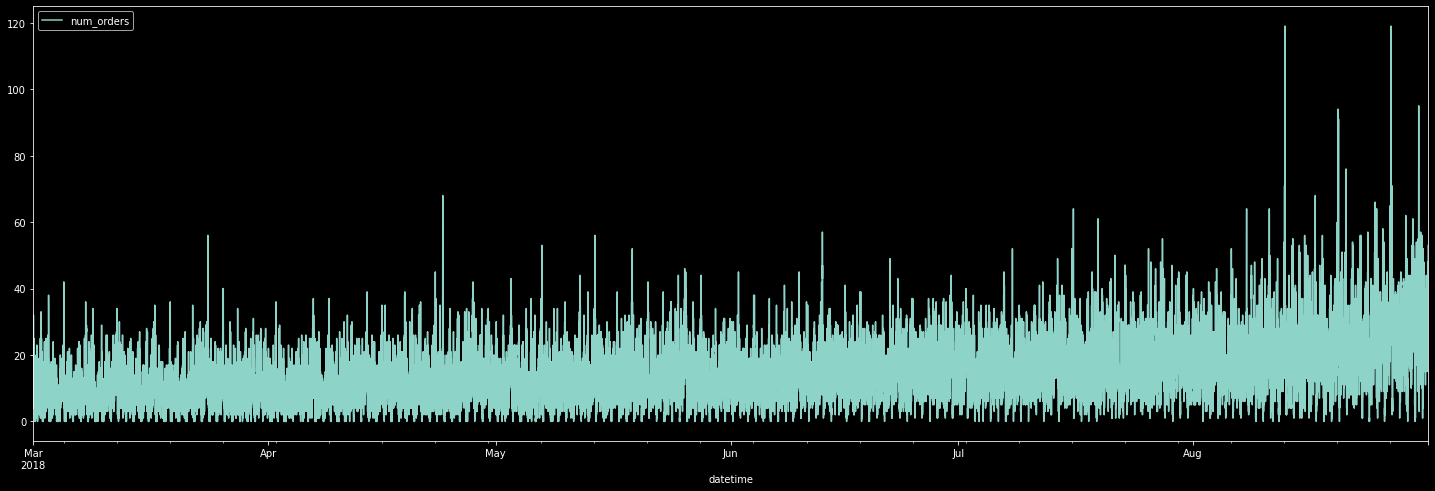

In [6]:
data.sort_index(inplace=True)
data.plot(figsize = (25,8));

In [7]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [8]:
df = data.copy()

In [9]:
df = df['2018-03-01':'2018-08-31'].resample('1H').sum()

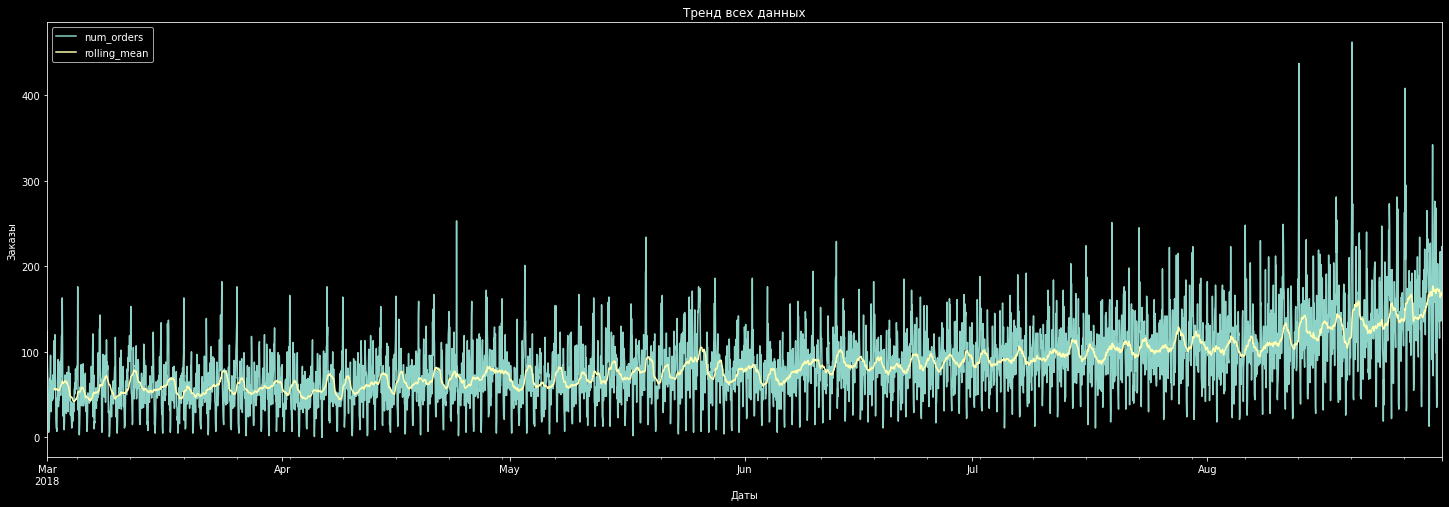

In [10]:
df['rolling_mean'] = df.rolling(24).mean()
df.plot(figsize = (25,8));plt.title("Тренд всех данных")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

In [11]:
print(df.index.is_monotonic)

True


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4393 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 103.5 KB


## Графики декомпозиций

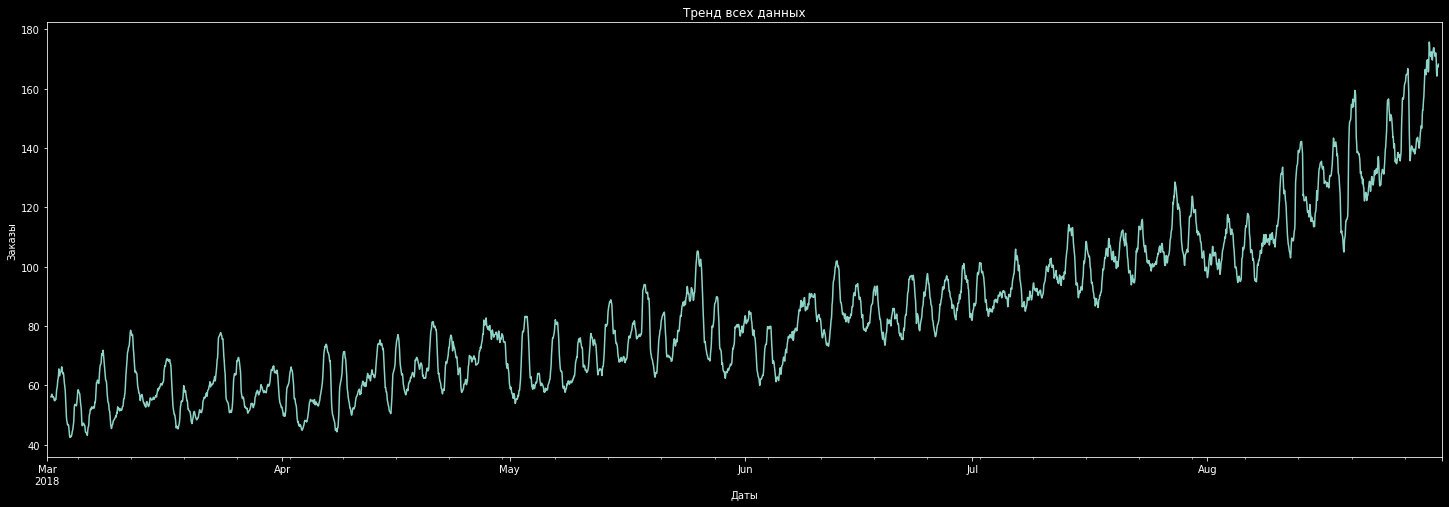

In [13]:
decomposed = seasonal_decompose(df.num_orders)

decomposed.trend.plot(ax=plt.gca(),figsize = (25,8));
plt.title("Тренд всех данных")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

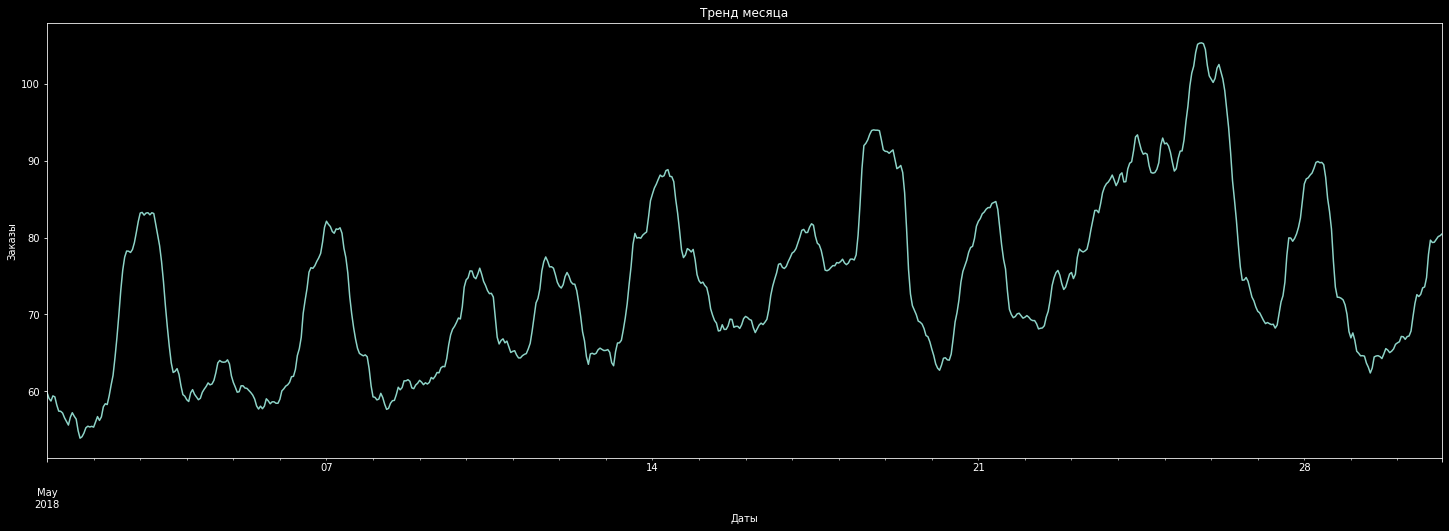

In [14]:
decomposed.trend['2018-05-01':'2018-05-30'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Тренд месяца")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

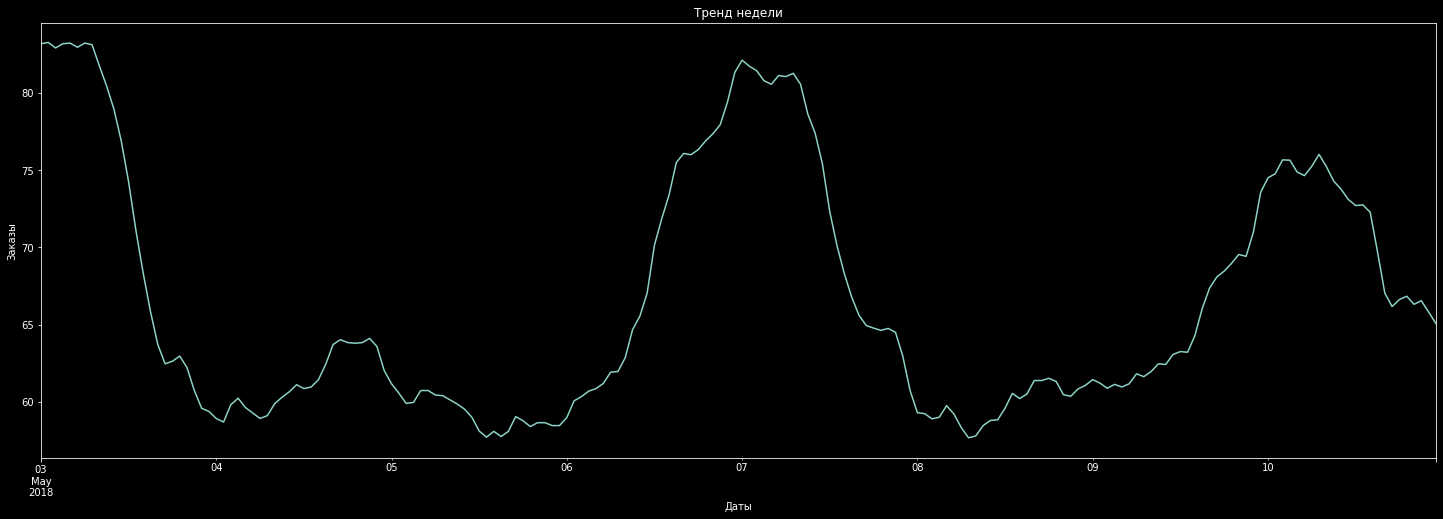

In [15]:
decomposed.trend['2018-05-03':'2018-05-10'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Тренд недели")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()


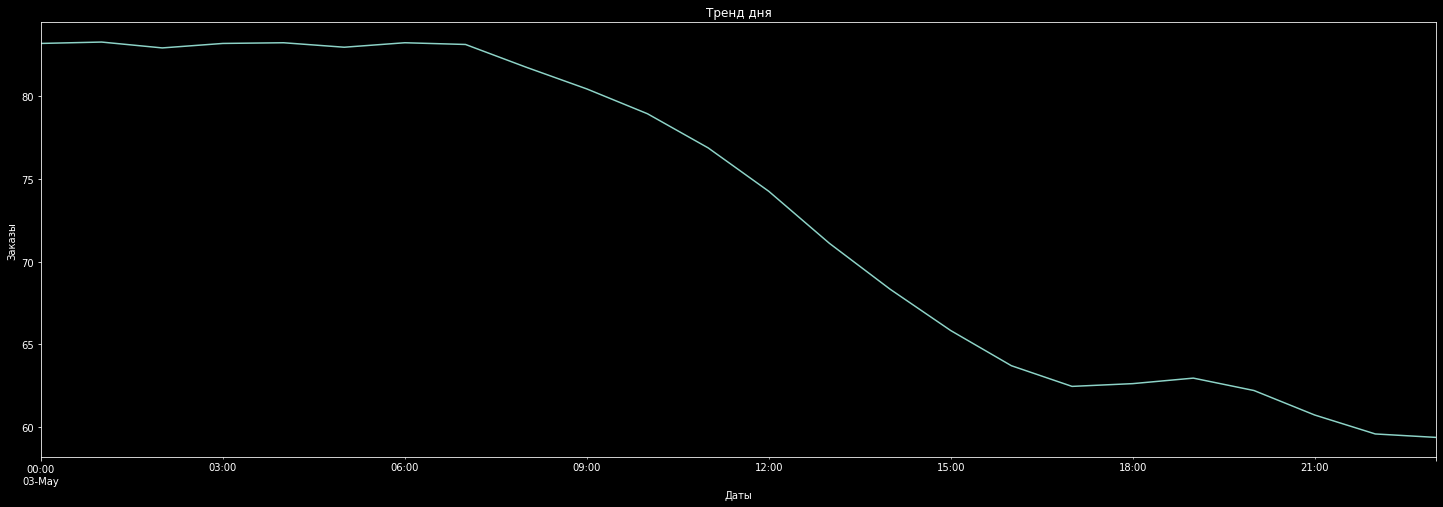

In [16]:
decomposed.trend['2018-05-03'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Тренд дня")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

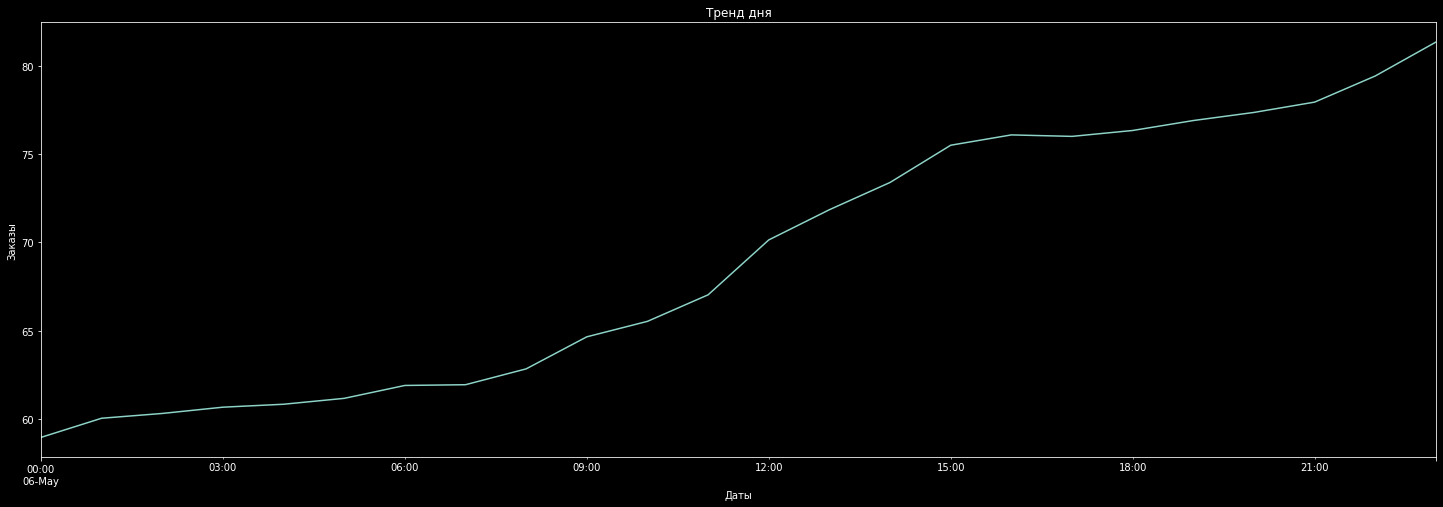

In [17]:
decomposed.trend['2018-05-06'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Тренд дня")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

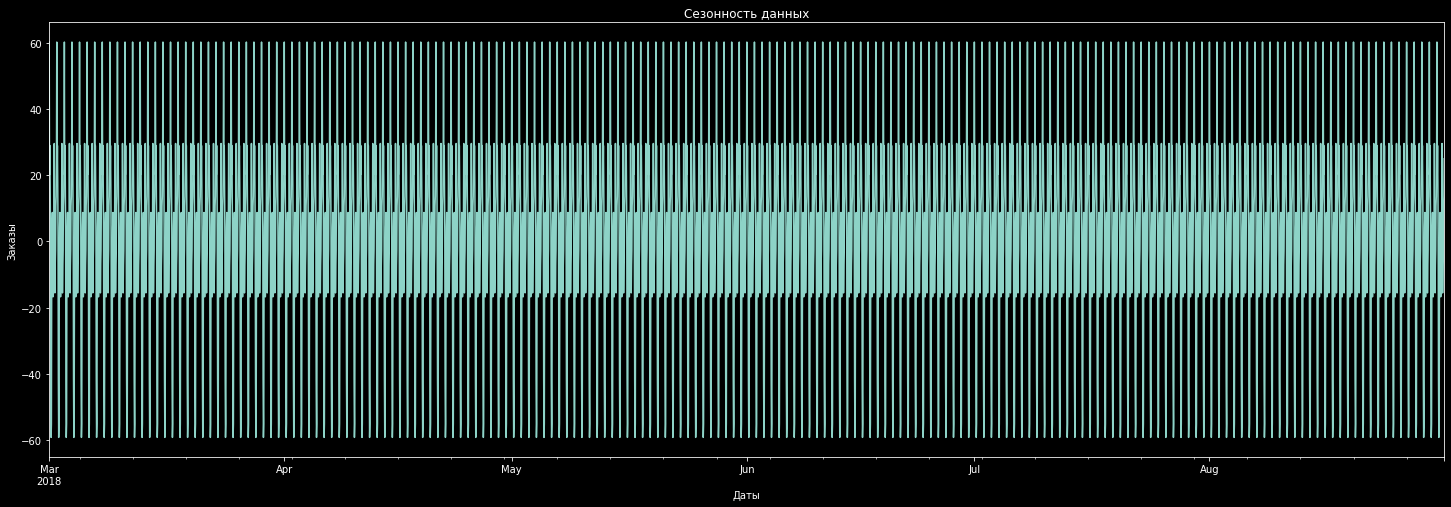

In [18]:
decomposed.seasonal.plot(ax=plt.gca(),figsize = (25,8));
plt.title("Сезонность данных")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

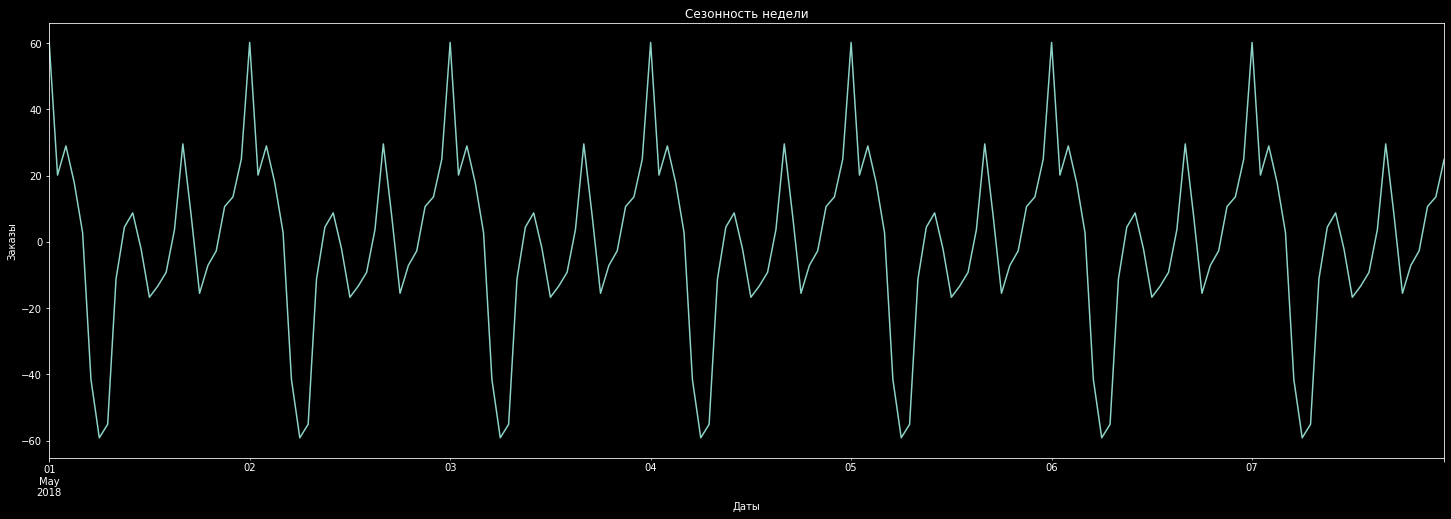

In [19]:
decomposed.seasonal['2018-05-01':'2018-05-07'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Сезонность недели")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

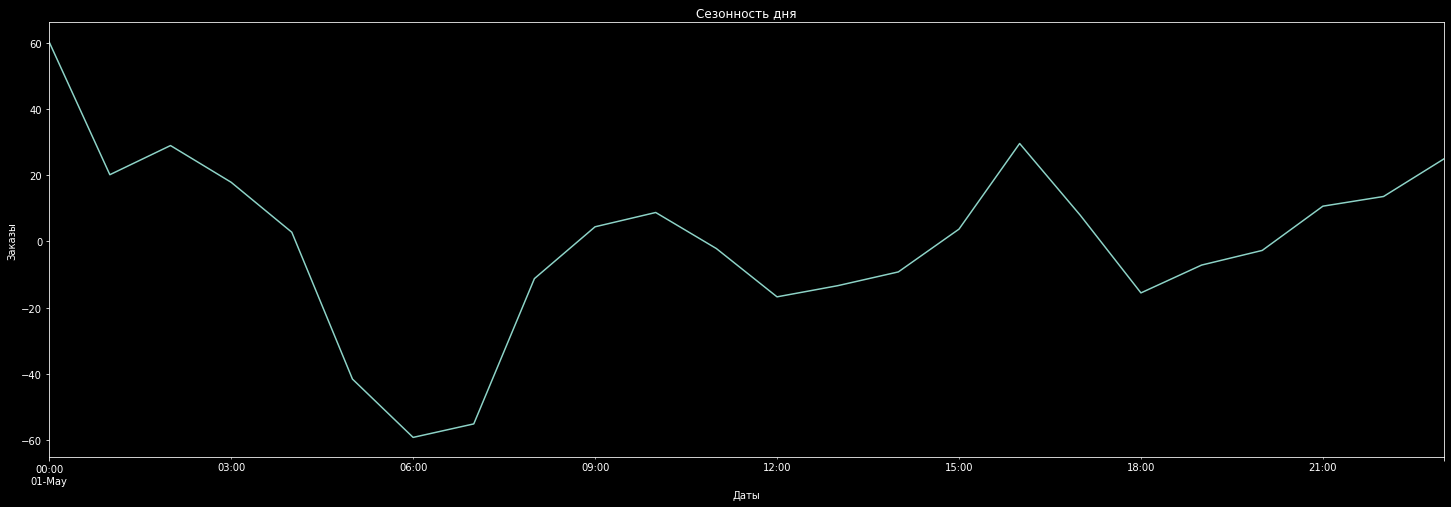

In [20]:
decomposed.seasonal['2018-05-01'].plot(ax=plt.gca(),figsize = (25,8));
plt.title("Сезонность дня")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

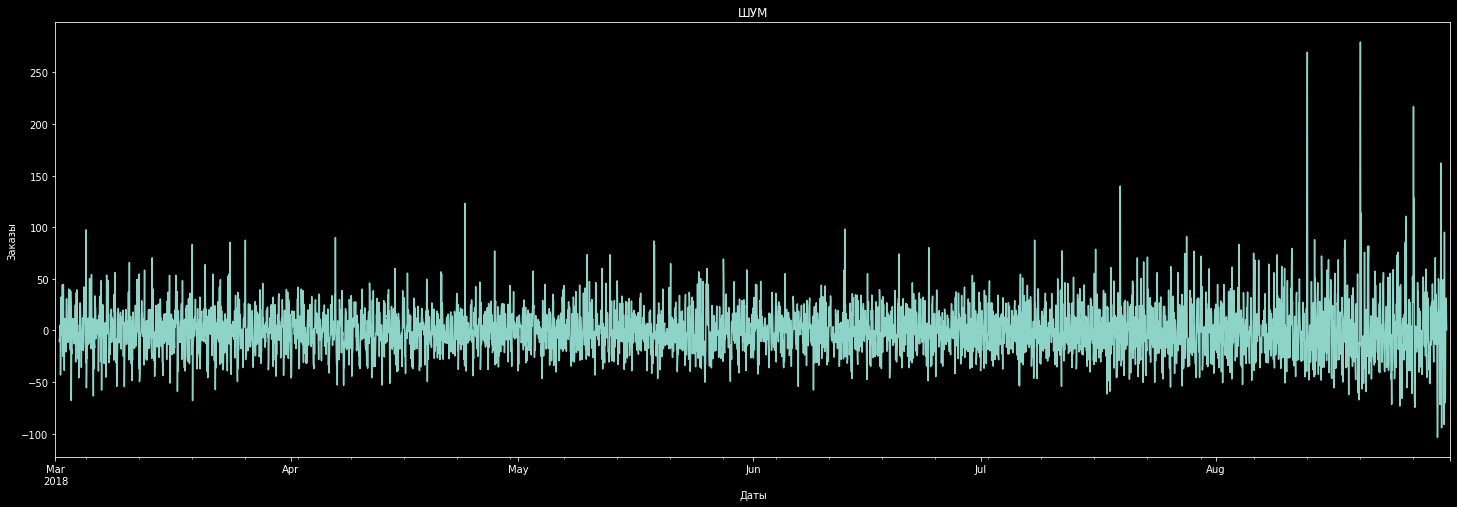

In [21]:
decomposed.resid.plot(ax=plt.gca(),figsize = (25,8));
plt.title("ШУМ")
plt.xlabel("Даты")
plt.ylabel("Заказы")
plt.show()

## Добавление признаков

In [22]:


lags_to_try = [1,2,23,24,25,48]

def make_features(data, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    
    for lag in lags_to_try:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag, fill_value= 0)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

make_features(df, 24)

df.head(10)

,num_orders,rolling_mean,month,day,dayofweek,lag_1,lag_2,lag_23,lag_24,lag_25,lag_48
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,0,0,0,0,0
2018-03-01 01:00:00,85,NaN,3,1,3,124,0,0,0,0,0
2018-03-01 02:00:00,71,NaN,3,1,3,85,124,0,0,0,0
2018-03-01 03:00:00,66,NaN,3,1,3,71,85,0,0,0,0
2018-03-01 04:00:00,43,NaN,3,1,3,66,71,0,0,0,0
2018-03-01 05:00:00,6,NaN,3,1,3,43,66,0,0,0,0
2018-03-01 06:00:00,12,NaN,3,1,3,6,43,0,0,0,0
2018-03-01 07:00:00,15,NaN,3,1,3,12,6,0,0,0,0
2018-03-01 08:00:00,34,NaN,3,1,3,15,12,0,0,0,0


In [23]:
df = df[48:]
df

,num_orders,rolling_mean,month,day,dayofweek,lag_1,lag_2,lag_23,lag_24,lag_25,lag_48
datetime,,,,,,,,,,,
2018-03-03 00:00:00,163,62.750000,3,3,5,72,119,120,90,58,124
2018-03-03 01:00:00,108,65.791667,3,3,5,163,72,75,120,90,85
2018-03-03 02:00:00,25,65.291667,3,3,5,108,163,64,75,120,71
2018-03-03 03:00:00,64,63.208333,3,3,5,25,108,20,64,75,66
2018-03-03 04:00:00,44,63.208333,3,3,5,64,25,11,20,64,43
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,8,31,4,207,217,142,72,177,169
2018-08-31 20:00:00,154,167.541667,8,31,4,136,207,198,142,72,191
2018-08-31 21:00:00,159,168.041667,8,31,4,154,136,158,198,142,170


## Промежуточный вывод

Данные при выгрузку представаляют из себя даты и количество заказов по часам

Для данных были приведены графики декомпозиции

Были добавлены дополнительные признаки с разными смещениями и удалены лишние - сообразно с добавленным смещением

# Обучение моделей

## Подготовка к обучению

In [24]:

tcv = TimeSeriesSplit(n_splits=8)

train, test = train_test_split(df, shuffle = False, test_size = 0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-03 00:00:00 2018-08-13 18:00:00
2018-08-13 19:00:00 2018-08-31 23:00:00


In [25]:
train = train.dropna()
 
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [26]:
rmse_score = make_scorer(mean_squared_error, squared=False)

## LR

In [27]:
model_lr = LinearRegression()
 
model_lr.fit(features_train, target_train)
rmse_lr_cv = cross_val_score(model_lr, features_train,target_train,cv=tcv,scoring = 'neg_root_mean_squared_error').mean()
print('Кроссвалидация : ', rmse_lr_cv)

test_pred = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, test_pred)**.5
print('Тест', rmse_lr)

Кроссвалидация :  -24.777014163149197
Тест 42.79641277812325


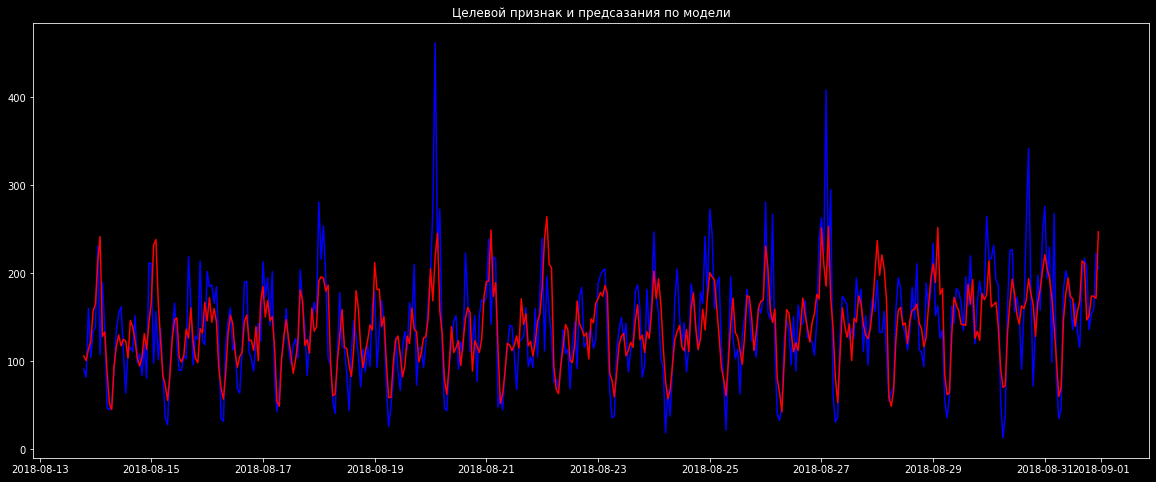

In [28]:
plt.figure(figsize=(20,8))
plt.title('Целевой признак и предсазания по модели')
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         test_pred,
         'r-');

## LR RS

In [29]:
model = LinearRegression()
param = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, 2, 4],
    'positive': [True, False]
}


grid_search = RandomizedSearchCV(model, param_distributions= param , cv=5, scoring='neg_mean_squared_error', n_jobs= -1)
grid_search.fit(features_train, target_train)
best_model = grid_search.best_estimator_
rmse_lrrs_cv = cross_val_score(model,features_train,target_train, scoring=rmse_score, cv = tcv).mean()
print('Кроссвалидация : ', rmse_lrrs_cv)


target_predict = best_model.predict(features_test)
rmse_lrrs = mean_squared_error(target_test, target_predict) ** 0.5
print('Тест : ' , rmse_lrrs)

Кроссвалидация :  24.777014163149197
Тест :  42.794564067799634


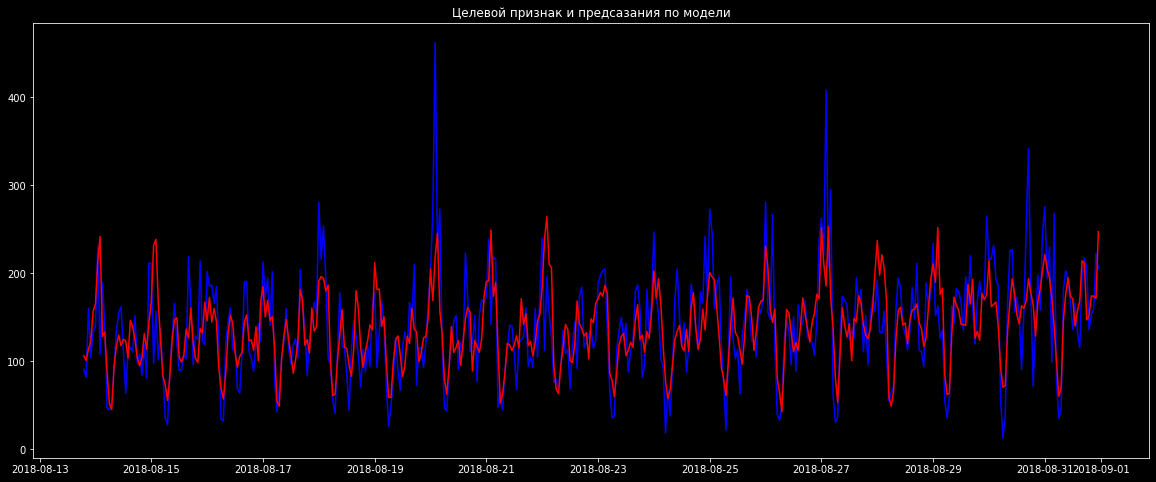

In [30]:
plt.figure(figsize=(20,8))
plt.title('Целевой признак и предсазания по модели')
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

## CB

In [31]:
col = ['month',	'day',	'dayofweek']

model = CatBoostRegressor(learning_rate=0.05, 
                          random_state=1515, 
                          verbose=False) \

model.fit(features_train, target_train, cat_features = col )
rmse_cb_cv = cross_val_score(model,features_train,target_train, scoring=rmse_score, cv = tcv).mean()
print('Кроссвалидация : ' , rmse_cb_cv)


target_predict = model.predict(features_test)
rmse_cb = mean_squared_error(target_test, target_predict) ** 0.5
print('Тест : ', rmse_cb)

Кроссвалидация :  25.415434993684563
Тест :  44.80362098757127


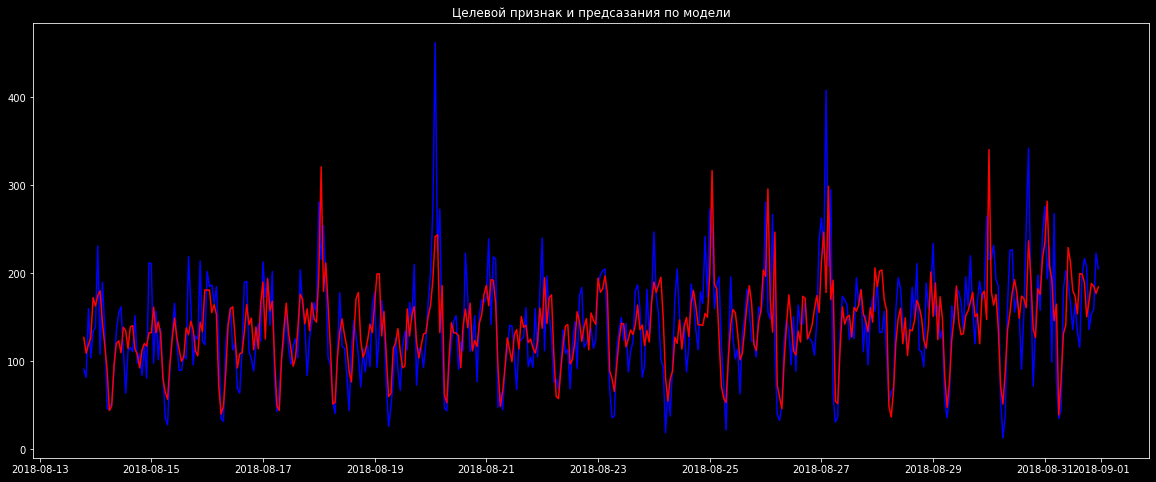

In [32]:
plt.figure(figsize=(20,8))
plt.title('Целевой признак и предсазания по модели')
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

## RF

In [33]:
param = {'n_estimators': [100, 200],
                      'max_depth': [5, 10, 15],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_split': [2, 5, 10],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}

In [34]:
rf_model = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=param,
                               n_iter=20,
                               cv=5,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(features_train, target_train)
rmse_rf_cv = cross_val_score(rf_random,features_train,target_train, scoring=rmse_score, cv = tcv, verbose=0).mean()
print('Кроссвалидация : ', rmse_rf_cv)

target_predict = rf_random.predict(features_test)
rmse_rf = (mean_squared_error(target_test, target_predict)**.5)
print('Тест : ', rmse_rf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200

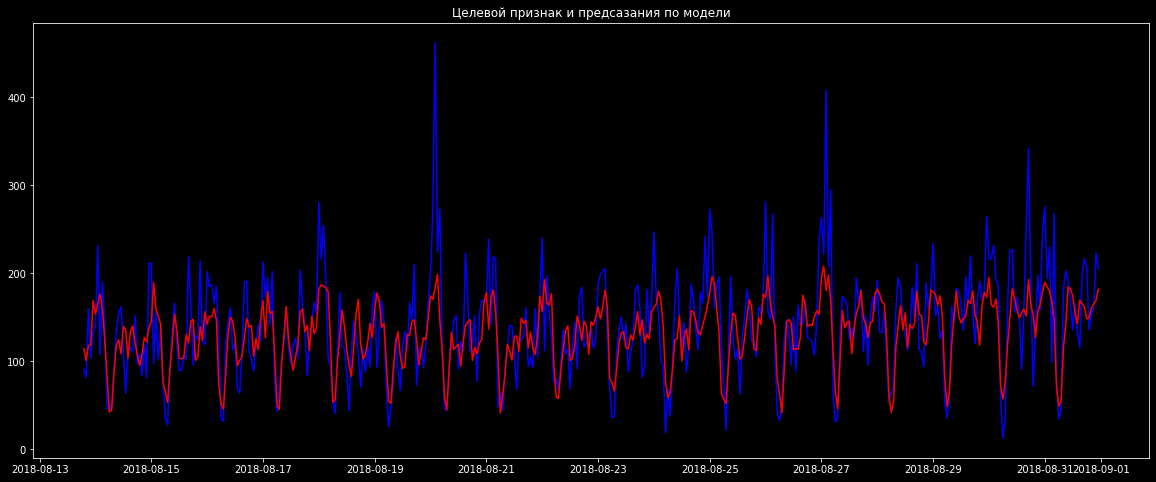

In [35]:
plt.figure(figsize=(20,8));
plt.title('Целевой признак и предсазания по модели')
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         target_predict,
         'r-');

# Итог работы

In [36]:
column = ['RMSE на CV']
index = ['LinearRegression',
         'LinearRegressorRS',
         'CatBoostRegressor',
         'RandomForestRegressorRS']
data = {'RMSE на CV':[-rmse_lr_cv,
                      rmse_lrrs_cv,
                      rmse_cb_cv,
                      rmse_rf_cv],
       }

scores_data = pd.DataFrame(data, index=index, columns = column)

df_styled = scores_data.style
df_styled.highlight_min(color='green', axis=0)
display(df_styled)

,RMSE на CV
LinearRegression,24.777014
LinearRegressorRS,24.777014
CatBoostRegressor,25.415435
RandomForestRegressorRS,24.807747


Для теста выбрана линейная регрессия и на тесте она показывет следующий показатель

In [37]:
test_pred = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, test_pred)**.5
print('Тест', rmse_lr)

Тест 42.79641277812325


# Вывод

В приведенной работе мы загрузили данные, изучили их.

Данные составляли из себя дату и количество заказов такси для каждого часа

Были построены графики по декомопозициям и добавлены признаки со смещением.

К обучению выбраны модели случайного леса, линейной регрессии и кэтбуст.

Все модели на тестовой выборке показали приемлимое качество.